In [1]:
import numpy as np
import csv
import matplotlib.pyplot as plt
from datetime import datetime
from math import *

date_format = "%m/%d/%Y"

In [2]:
class Bond():
    def __init__(self, data):
        self.coupon = float(data[0])
        self.matur = datetime.strptime(data[1], date_format)
        self.prices = []
        for i in range(2, len(data)):
            self.prices.append(float(data[i]))

In [3]:
# Import and set up data
dates = ['1/10/2022', '1/11/2022', '1/12/2022', '1/13/2022', '1/14/2022', 
         '1/17/2022', '1/18/2022', '1/19/2022', '1/20/2022', '1/21/2022']
formatted_dates =  []
for d in dates:
    a = datetime.strptime(d, date_format)
    formatted_dates.append(a)
    
bonds = []
with open('selected_bonds.csv', newline='') as filename:
    csvreader = csv.reader(filename)
    for row in csvreader:
        b = Bond(row)
        bonds.append(b)

In [18]:
# Calculate yield curve
def yield_equation(price, coupon, matur, cur_date, rate):
    ans = price
    t = (matur - cur_date).days # days till maturity
    t /= 365.0 # convert to years
    ans -= 100 * exp(-rate * t)
    while t > 0:
        ans -= coupon * exp(-rate * t)
        t -= 0.5
        
    ans += coupon * (-2*t) # add accrued interest
    return ans

def find_yield_rate(price, coupon, matur, cur_date):
    """
    find_yield_rate uses binary search to find the ytm
    """
    lo = 0
    hi = 0.1
    while lo < hi:
        mid = (lo + hi) / 2
        ans = yield_equation(price, coupon / 2, matur, cur_date, mid)
        # divide coupon by 2 since there are 2 coupon payments per year
        if abs(ans) < 0.0001:
            return mid * 100
        elif ans > 0:
            hi = mid
        else:
            lo = mid
            
yields = []
times = []
# for each day, calculate the ytm for each bond
for i in range(len(formatted_dates)):
    day_curve = []
    matur_times = []
    for b in bonds:
        r = find_yield_rate(b.prices[i], b.coupon, b.matur, formatted_dates[i])
        t = (b.matur - formatted_dates[i]).days
        t /= 365.0
        matur_times.append(t)
        day_curve.append(r)
        
    yields.append(day_curve)
    times.append(matur_times)

print(yields[0])

[0.20751953125, 0.80810546875, 0.9606933593750002, 1.07574462890625, 1.17828369140625, 1.2874603271484375, 1.3628387451171873, 1.4397048950195312, 1.4673233032226562, 1.5179824829101562, 1.5670013427734375]


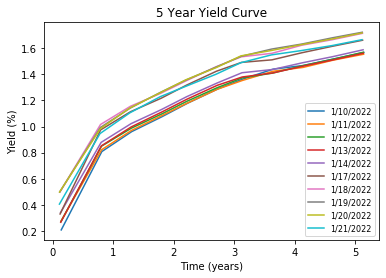

In [25]:
# Plot yield curve
for i in range(len(yields)):
    plt.plot(times[i], yields[i], label=dates[i])
plt.title("5 Year Yield Curve")
plt.xlabel("Time (years)")
plt.ylabel("Yield (%)")
plt.legend(prop={'size': 8})
plt.savefig('yield.png')

# Yield curve has up and down movement since not all bonds have exact same coupon.

In [20]:
# calculate spot curve
spot_rates = []
def spot_equation(price, coupon, matur, cur_date, rate):
    ans = price
    t = (matur - cur_date).days # days till maturity
    t /= 365.0 # convert to years
    ans -= (100 + coupon) * exp(-rate * t)
    t -= 0.5
    i = 0
    while t > 0: # discount coupon at the corresponding spot rate
        ans -= coupon * exp(-spot_rates[i] * t)
        i += 1
        t -= 0.5
        
    ans += coupon * (-2*t) # add accrued interest
    return ans

def find_spot_rate(price, coupon, matur, cur_date):
    """
    Use binary search to find the spot rate from the spot equation
    """
    lo = 0
    hi = 0.1
    while lo < hi:
        mid = (lo + hi) / 2
        ans = spot_equation(price, coupon / 2, matur, cur_date, mid) 
        # divide coupon by 2 since there are 2 coupon payments per year
        if abs(ans) < 0.0001:
            spot_rates.insert(0, mid)
            return mid * 100
        elif ans > 0:
            hi = mid
        else:
            lo = mid
            
spots = []
times = []
# for each day, calculate the ytm for each bond
for i in range(len(formatted_dates)):
    day_curve = []
    matur_times = []
    spot_rates = []
    for b in bonds:
        r = find_spot_rate(b.prices[i], b.coupon, b.matur, formatted_dates[i])
        t = (b.matur - formatted_dates[i]).days
        t /= 365.0
        matur_times.append(t)
        day_curve.append(r)
        
    spots.append(day_curve)
    times.append(matur_times)
    
print(spots[0])
# spot rates are slightly different from ytm
# the later spot rates are larger than ytm which is to be expected

[0.20751953125, 0.8084106445312499, 0.9609985351562502, 1.07666015625, 1.1788177490234375, 1.2896728515625, 1.3669586181640623, 1.4417648315429688, 1.468353271484375, 1.5227890014648438, 1.5738677978515625]


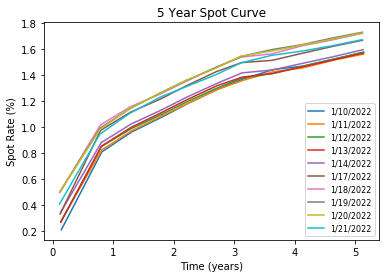

In [21]:
# Plot spot curve
for i in range(len(spots)):
    plt.plot(times[i], spots[i], label=dates[i])
plt.title("5 Year Spot Curve")
plt.xlabel("Time (years)")
plt.ylabel("Spot Rate (%)")
plt.legend(prop={'size': 8})
plt.savefig('spot.png')

In [22]:
# calculate forward curve

year_spot_rates = []
for i in range(len(dates)):
    # interpolate spot rates to exactly 1 year marks
    spots_today = []
    s = spots[i]
    t = times[i]
    for j in range(1, 6):
        t1 = t[2*j-1]
        t2 = t[2*j]
        s1 = s[2*j-1]
        s2 = s[2*j]
        ratio = (j-t1) / (t2-t1)
        spot = ratio * s1 + (1 - ratio) * s2
        spots_today.append(spot)
    year_spot_rates.append(spots_today)

forwards = []
years = []
# calculate forward rates
for i in range(len(formatted_dates)):
    spots_today = year_spot_rates[i]
    forward = []
    for j in range(1, 5):
        f = (spots_today[j] * (j+1) - spots_today[0]) / (j)
        forward.append(f)
    forwards.append(forward)
    years.append([1,2,3,4])

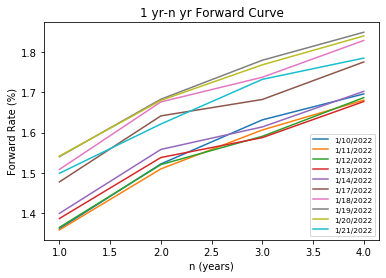

In [28]:
# Plot forward curve
for i in range(len(forwards)):
    plt.plot(years[i], forwards[i], label=dates[i])
plt.title("1 yr-n yr Forward Curve")
plt.xlabel("n (years)")
plt.ylabel("Forward Rate (%)")
plt.legend(prop={'size': 7.5})
plt.savefig('forward.png')

In [26]:
# Calculate yield covariance and get eigenvalues/eigenvectors
def calculate_covariance(r1, r2):
    ans = np.dot(r1, r2) / len(r1)
    return ans

# interpolate to find n year yields
year_yield_rates = []
for i in range(len(dates)):
    yield_today = []
    y = yields[i]
    t = times[i]
    for j in range(1, 6):
        t1 = t[2*j-1]
        t2 = t[2*j]
        y1 = y[2*j-1]
        y2 = y[2*j]
        ratio = (j-t1) / (t2-t1)
        yiel = ratio * y1 + (1 - ratio) * y2
        yield_today.append(yiel)
    year_yield_rates.append(yield_today)

yield_returns = []
for i in range(5): # calculate log returns
    y = []
    for j in range(len(dates)-1):
        x = log(year_yield_rates[j+1][i] / year_yield_rates[j][i])
        y.append(x)
    yield_returns.append(y)

cov1 = []
for i in range(5): # calculate covariance matrix
    row = []
    for j in range(5):
        x = calculate_covariance(yield_returns[i], yield_returns[j])
        row.append(x)
    cov1.append(row)

print("Covariance Matrix for Yield")
for row in cov1:
    print(row)
    
# eigenvectors from np.linalg.eig are the columns (not the rows)
w, v = np.linalg.eig(cov1)
print()
print("Eigenvalues and Eigenvectors")
for i in range(5):
    print(w[i], 10*v[:,i])

Covariance Matrix for Yield
[0.001394538943408294, 0.0010175208281214437, 0.0009442887153781093, 0.0007300913273194745, 0.0007785611038696959]
[0.0010175208281214437, 0.0007929806738160832, 0.0007298329372934605, 0.0005988607292293802, 0.0006098375590663566]
[0.0009442887153781093, 0.0007298329372934605, 0.0006863184586533411, 0.0005549130090781898, 0.0005738407904036305]
[0.0007300913273194745, 0.0005988607292293802, 0.0005549130090781898, 0.0005469503516103548, 0.0005172144978239956]
[0.0007785611038696959, 0.0006098375590663566, 0.0005738407904036305, 0.0005172144978239956, 0.0005216220700712487]

Eigenvalues and Eigenvectors
0.0037497479299700405 [-5.9648497  -4.56261287 -4.24386816 -3.53286775 -3.62098885]
0.00015064716117835423 [ 5.98045345  0.42543191  0.23296332 -7.04864413 -3.78358669]
2.5021865349556263e-05 [-4.92741944  6.05978214  4.86737952 -1.78524617 -3.48153569]
3.4779728021834748e-06 [ 1.20928813 -5.27790728  5.38299912  3.71925533 -5.27937281]
1.3515568259187768e-05 [

In [27]:
# Calculate forward covariance and get eigenvalues/eigenvectors
forward_x = []
for i in range(4): # calculate log returns
    f = []
    for j in range(len(dates)-1):
        x = log(forwards[j+1][i] / forwards[j][i])
        f.append(x)
    forward_x.append(f)

cov2 = []
for i in range(4): # calculate covariance matrix
    row = []
    for j in range(4):
        x = calculate_covariance(forward_x[i], forward_x[j])
        row.append(x)
    cov2.append(row)

print("Covariance Matrix for Forward Rates")
for row in cov2:
    print(row)
w, v = np.linalg.eig(cov2)
print()
print("Eigenvalues and Eigenvectors")
for i in range(4):
    print(w[i], 10*v[:,i])

Covariance Matrix for Forward Rates
[0.0005526033522909338, 0.0005224446083253371, 0.00045582677261178276, 0.00045114785557581635]
[0.0005224446083253371, 0.0005396596175746599, 0.00043593576832419705, 0.000463623190532167]
[0.00045582677261178276, 0.00043593576832419705, 0.0004909163172862142, 0.00044298124492423547]
[0.00045114785557581635, 0.000463623190532167, 0.00044298124492423547, 0.00045197635811457276]

Eigenvalues and Eigenvectors
0.0018980913240900029 [5.23562362 5.1804265  4.80082251 4.76482211]
9.279380525737984e-05 [ 4.10075301  4.89948868 -7.27385733 -2.50396384]
3.7984690129745724e-05 [ 6.45136706 -3.93452882  2.99247563 -5.82618534]
6.285825789252442e-06 [ 3.76190553 -5.80324692 -3.88435223  6.08951555]
